In [1]:
# Step 1: Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [7]:
# Step 2: Load and Prepare Data
df = pd.read_csv(r"C:\Users\91808\Downloads\exchange_rate.csv", parse_dates=[0])
df.columns = ['Date', 'USD_to_AUD']
df.set_index('Date', inplace=True)
df

,USD_to_AUD
Date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


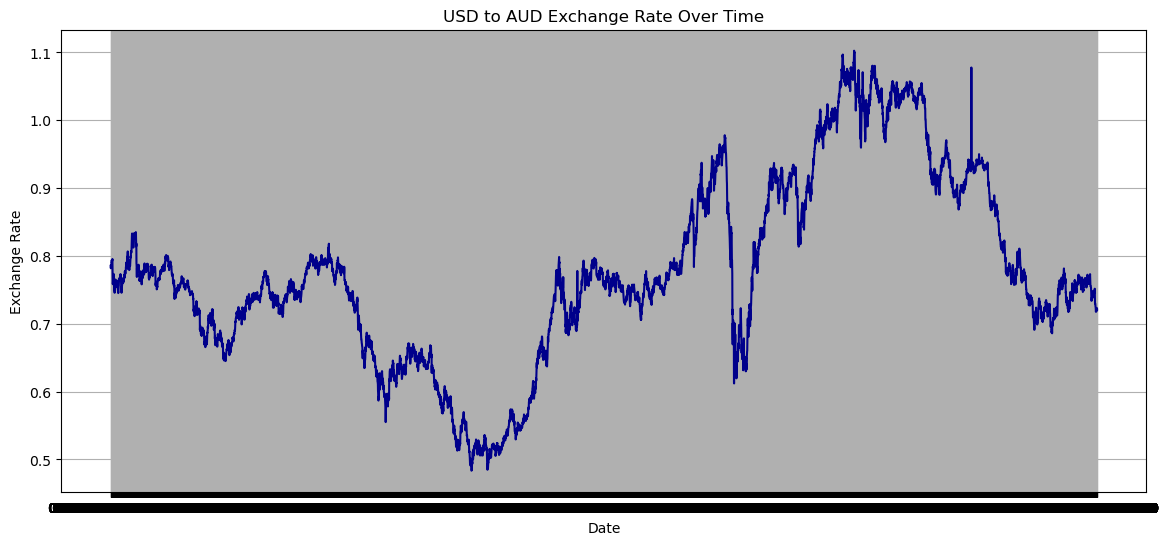

In [8]:
# Step 3: Plot Time Series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['USD_to_AUD'], color='darkblue')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [15]:
# Step 4: Check for Missing Values
print("Missing values:\n", df.isnull().sum())
df = df.fillna(method='ffill')  # Forward-fill missing values
import warnings
warnings.filterwarnings('ignore')

Missing values:
 USD_to_AUD    0
dtype: int64


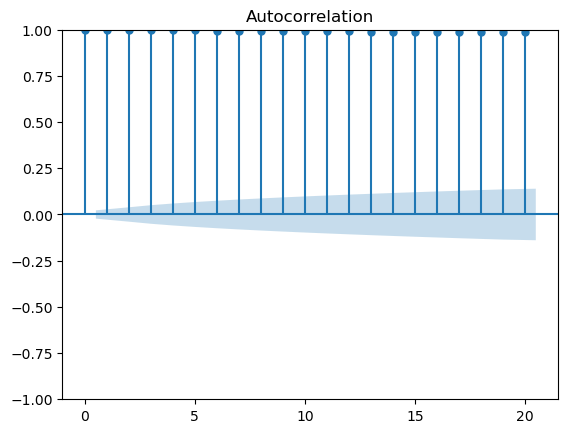

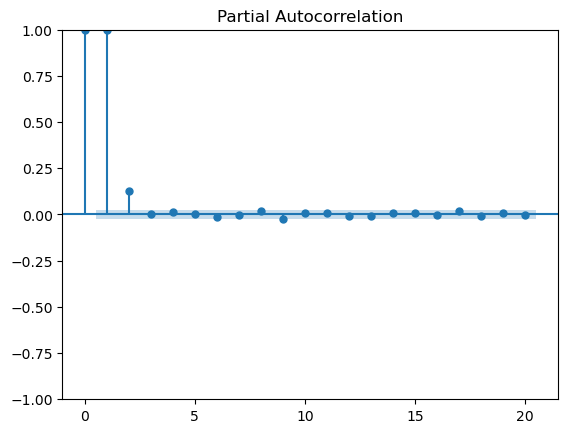

In [14]:
# Step 5: ACF and PACF Plots
plot_acf(df['USD_to_AUD'], lags=20)
plot_pacf(df['USD_to_AUD'], lags=20)
plt.show()

In [16]:
# Step 6: Fit ARIMA Model
model_arima = ARIMA(df['USD_to_AUD'], order=(1, 1, 1))  # Example (p=1, d=1, q=1)
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             USD_to_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 22 Apr 2025   AIC                         -56102.322
Time:                        16:42:12   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.0

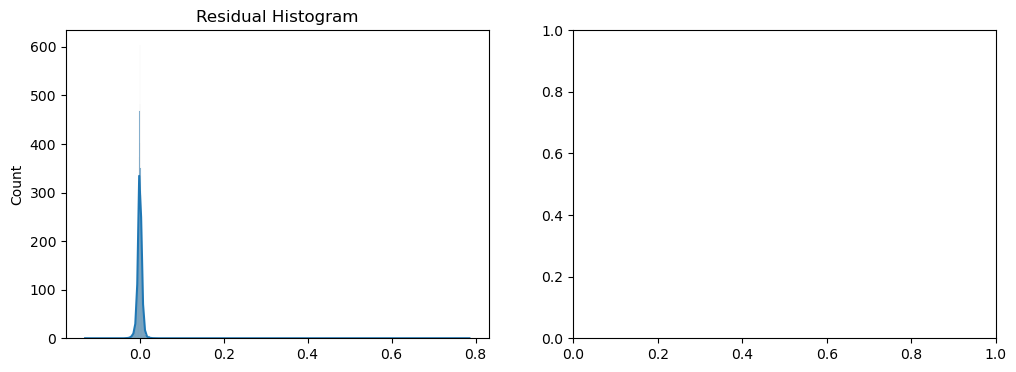

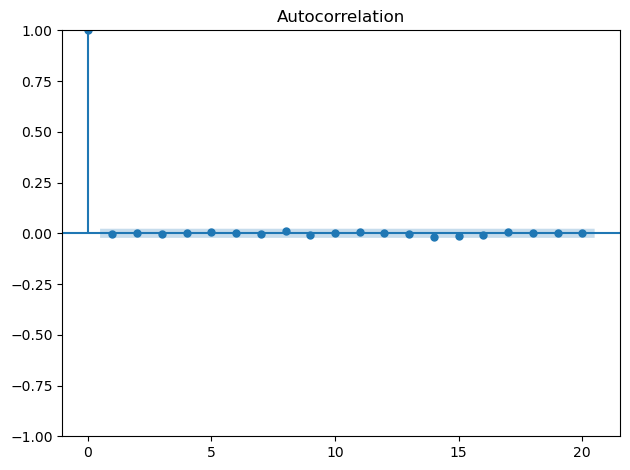

In [17]:
# Step 7: Residual Diagnostics
residuals = results_arima.resid
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Residual Histogram")
plt.subplot(1, 2, 2)
plot_acf(residuals, lags=20)
plt.tight_layout()
plt.show()

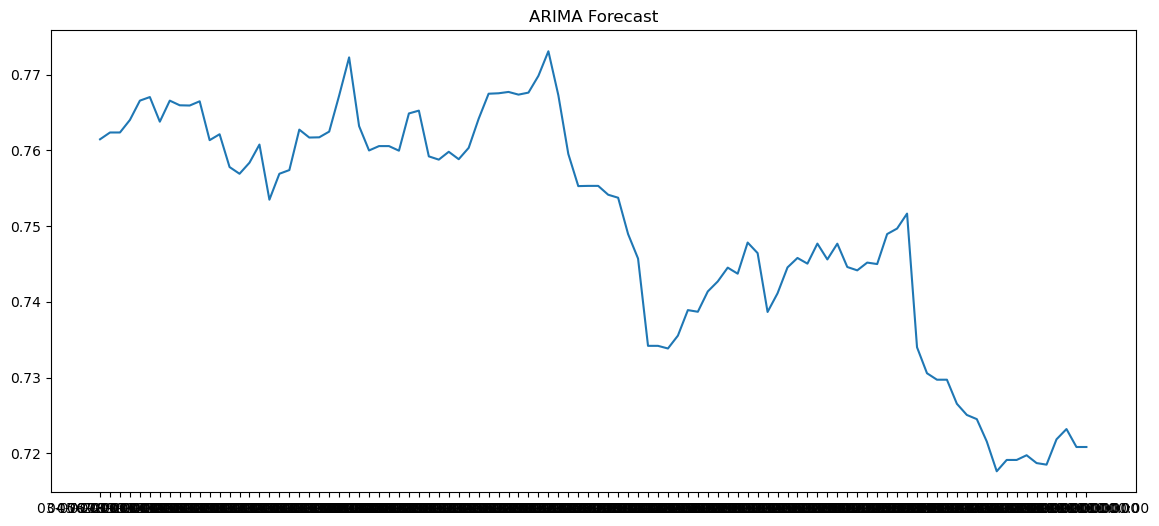

In [23]:
# Step 8: ARIMA Forecast
n_forecast = 24
forecast_arima = results_arima.forecast(steps=n_forecast)
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['USD_to_AUD'][-100:], label='Actual')
plt.title('ARIMA Forecast')
plt.show()

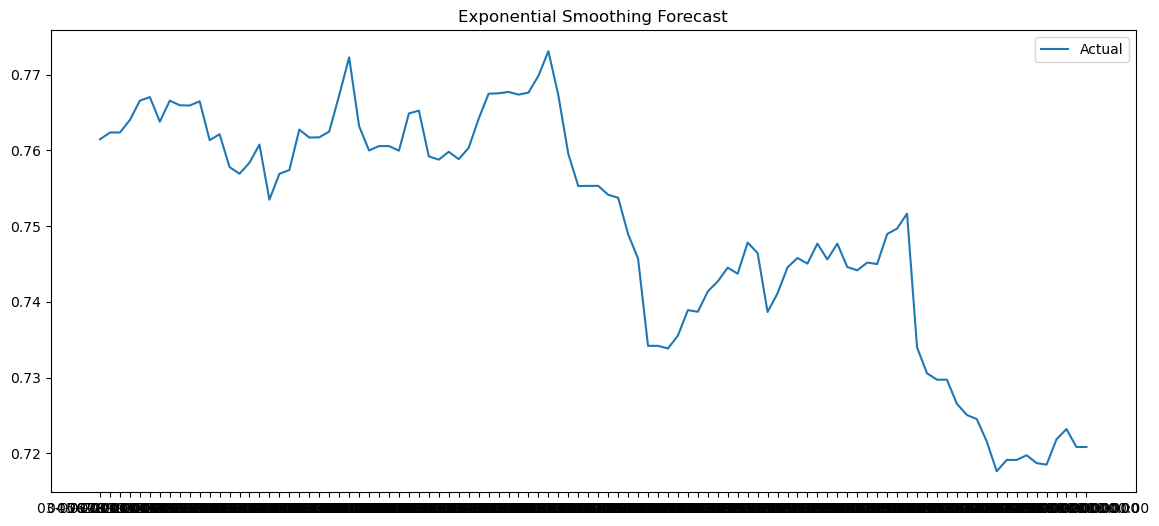

In [25]:
# Step 9: Holt-Winters Model (Exponential Smoothing)
model_es = ExponentialSmoothing(df['USD_to_AUD'], trend='add', seasonal=None)
fit_es = model_es.fit()
forecast_es = fit_es.forecast(n_forecast)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['USD_to_AUD'][-100:], label='Actual')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

In [26]:
# Use the last 24 months for evaluation
test_data = df['USD_to_AUD'][-24:]
train_data = df['USD_to_AUD'][:-24]

# Refit models on train data
arima_model = ARIMA(train_data, order=(1,1,1)).fit()
es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()

arima_pred = arima_model.forecast(steps=24)
es_pred = es_model.forecast(steps=24)

# Error metrics
def print_errors(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

print_errors(test_data, arima_pred, "ARIMA")
print_errors(test_data, es_pred, "Exp Smoothing")

ARIMA - MAE: 0.0169, RMSE: 0.0192, MAPE: nan%
Exp Smoothing - MAE: 0.0168, RMSE: 0.0192, MAPE: nan%
